In [383]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from pymongo import MongoClient
from nltk.tokenize import word_tokenize

In [227]:
# load nltk's SnowballStemmer
from nltk.stem.snowball import SnowballStemmer
stemmer_eng = SnowballStemmer("english", ignore_stopwords=True)
stemmer_germ = SnowballStemmer("german", ignore_stopwords=True)

In [228]:
#german cities
from bundeslander import Baden_Württemberg, Bayern, Berlin, Brandenburg, Bremen, Hamburg, Hessen, Mecklenburg_Vorpommern, Niedersachsen, Nordrhein_Westfalen, Rheinland_Pfalz, Saarland, Sachsen, Sachsen_Anhalt, Schleswig_Holstein, Thüringen, Ausland
All = Baden_Württemberg + Bayern + Berlin + Brandenburg + Bremen +Hamburg + Hessen + Mecklenburg_Vorpommern + Niedersachsen + Nordrhein_Westfalen + Rheinland_Pfalz + Saarland + Sachsen + Sachsen_Anhalt + Schleswig_Holstein + Thüringen + Ausland

In [229]:
cities = list(set([city.lower() for city in All]))

In [376]:
db_loc = {
    'ip' :'10.10.250.0',
    'port' : 27017,
    'db' : 'projectfinder',
    'coll' : 'itproject_clean'
}

In [377]:
db_data = {
    'ip' :'10.10.250.0',
    'port' : 27017,
    'db' : 'projectfinder',
    'coll' : 'mldata1'
}

In [378]:
def load_data_from_momgodb(db_obj):
    dbname = db_obj['db']
    ip = db_obj['ip']
    port = db_obj['port']
    coll = db_obj['coll']
    connection = MongoClient(ip,port)
    db = connection[dbname]
    exclude_data = {'_id': False}
    raw_data = list(db[coll].find({}, projection=exclude_data))
    dataset = pd.DataFrame(raw_data)
    print(f'Data loaded from mongodb {coll} collection succesfully')
    return dataset

In [379]:
def save_to_momgodb(df,db_):
    data = df.to_dict(orient='records')
    dbname = db_['db']
    ip = db_['ip']
    port = db_['port']
    coll = db_['coll']
    connection = MongoClient(ip,port)
    db = connection[dbname]
    col = db[coll].insert_many(data)
    print(f'data saved as {coll}')

In [380]:
def load_data_from_json(data):
    with open(data) as f:
            d = json.load(f)
        #normalize json
    dataset= json_normalize(d)
    return dataset

In [381]:
def clean_dataset(data):
    #select colunms
    df = data[['description', 'bereich']]
    df = df[df['description'] != '']
    df['project'] = df['description']
    df['label'] = df['bereich']
    df.drop(['description', 'bereich'], axis=1, inplace=True)
    df = df[df['label'] != 'IT/Bauingenieur']
    df = df.drop_duplicates()
    return df

In [384]:
df = load_data_from_momgodb(db_loc)

Data loaded from mongodb itproject_clean collection succesfully


In [386]:
df.shape

(14059, 25)

In [388]:
df = clean_dataset(df)
df.head()

,project,label
0,Für einen unserer Kunden aus dem Finanzdienstl...,Infr-Admin-Microsoft
1,Kann Profil leider nicht löschen.,IT/Consulting
2,Business Intelligence Analyst (m/w) - Tableau ...,Data-Sci-BI
3,"Konzeption, Customizing sowie Softwareanpassun...",Dev-Web-Backend
4,Es sollen mehrere Automatisierungen mit ubot S...,IT/IT


In [389]:
df.shape

(12130, 2)

In [390]:
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,project,label
0,für einen bestehenden Auftrag bei einem unsere...,IT/Produktionst
1,"Für meinen Kunden in Hamburg, suche ich einen ...",IT/Rechnungswes
2,Scrum Master (w/m) im GR Dortmund für 12+ Mona...,SW-Dev-Others
3,Projektbeschreibung \n\n ...,SW-Dev-Others
4,Selbstständige Bearbeitung von Administrations...,SW-Dev-Others


In [393]:
df.iloc[0,0]

'für einen bestehenden Auftrag bei einem unserer Direktkunden suchen wir eine(n) \n \nSenior Prozessplaner Frontantriebler KFZ-Vormontage (m/w) \nBeginn: a.s.a.p. / Dauer: 12 Monate / Ort: Raum Baden-Baden / Projekt-ID: 3903 \n \nUnser Kunde ist einer der Top Global Player der Automotive Industrie. Als Senior Prozessplaner unterstützen Sie das Team bei der Beplanung und Ausplanung neuer und vorhandener Arbeitsplätze, sind verantwortlich für MTM-Analysen, inkl. der Erstellung von Handlungsempfehlungen.  \n \nIhre Aufgaben: \no\tBeplanung und Ausplanung neuer und vorhandener Arbeitsplätze \no\tDurchführung von MTM-Anlaysen \no\tAnalyse und Optimierung von Montageabläufen in den Bereichen Motoren, Lenkung und Abgasanlagen \no\tErstellung von Materiallayouts \no\tAnalyse von Zeitaufwänden und Optimierung von nicht produktiven Zeiten \no\tErstellung und Präsentation von Handlungsempfehlungen \n \nIhr Profil: \no\tMehrjährige Erfahrung innerhalb der Automobilindustrie mit Schwerpunkte Montag

In [394]:
# load nltk's German and english stopwords'
import nltk
with open('../german_stopwords_full.txt', 'r') as f:
    stopwords_germ = f.read().splitlines()

stopwords_eng = nltk.corpus.stopwords.words('english')
extra = ['projektbeschreibung', 'melden', 'sich', 'jetzt', 'bewerben', 'direkt', 'jetzt', 'bewerben', 'unser', 'kunde','deutscher','bewerben', 'bewerb', 'koln', 'köln' 'direkt','herzlichen', 'melden', 'www', 'contactor', 'erfahrung', 'kenntnisse', 'kenntnis''contractor','https','de','impressum','munchen', 'münchen','frankfurt', 'suchen', 'kunden','bitte', 'inkl', 'bereich', 'einsatzort', 'dauer', 'umfeld', 'gmbh', 'pt', 'aufgaben', 'anforderungen', 'informationen', 'kunden', 'münchen', 'referenz', 'aufnehmen', 'profitieren', 'email', 'freuen', 'vorteile', 'ansprechpartner', 'beginn', 'qualifikation', 'referenznummer', 'unternehmen', 'dauer', 'passende', 'positionen', 'hays', 'kontakt', 'aufgaben']
extra1 = ['ort', 'customizing', 'freuen', 'fiori', 'bitte', 'basis', 'months', 'team', 'location', 'good', 'work', 'working', 'freitag', 'client', 'looking', 'knowledge', 'skills', 'experience', 'auftraggebers', 'jan', 'interessanten', 'selbstverständlich', 'bieten', 'freundlichen','understanding', 'service','firmensitz', 'fax', 'mobil', 'information', 'hrb', 'geschäftsführer','expertise', 'ready', 'honorarsatz', 'excellence', 'spannenden','abhängig', 'interessen', 'abwechslungsreiche', 'aussicht', 'aufgabe',]
extra2 = ['remote', 'interesse', 'laufzeit', 'freue', 'gerne', 'projekt', 'raum', 'auslastung','start', 'monate', 'erstellung','anzahl', 'personen', 'tagessatzes','völlig', 'bond', 'amoria', 'rahmenbedingungen', 'interessante', 'sicher', 'stellen', 'sektor', 'öffentlichen', 'experten','wachsen', 'frau', 'gestaltungsmöglichkeiten', 'arbeitsbereiches',  'grad', 'neueste', 'universität', 'gezielte', 'teamfähigkeit', 'engagierten', 'vorteil', 'mindestens', 'join', 'bewerbungsunterlagen', 'kommunikation', 'yrs','bitten']
extra3 = ['zeitraum', 'profil', 'senden', 'format', 'std','geehrte', 'damen', 'herren', 'verfügung', 'aktuell','woche','senior','möchten', 'gewünschten','new', 'product', 'strong', 'language','based', 'new', 'teams', 'contact', 'tasks','role', 'end', 'customer', 'required', 'michael', 'bailey', 'vermitteln', 'unterbreiten', 'pdf', 'intensiven','high', 'code', 'communication','holger', 'manager', 'anfragen', 'beratung', 'accounting', 'zukommen', 'lassen', 'munich','kompetenzen', 'verfügt', 'breites',  'individuellen', 'erbracht', 'standards', 'ag', 'isax', 'komponenten', 'abgabefrist', 'technischen', 'kompetent']
extra4 = ['königstein', 'percision', 'eu', 'id', 'verfügbarkeit', 'freuen', 'sofort', 'option', 'grüßen', 'profil', 'bitte', 'unseren', 'bewerbung', 'köln', 'mail', 'herr', 'zusendung','connect', 'alexander', 'nutzen','registrieren', 'rollout', 'angebot', 'erstellen', 'zusammenarbeit', 'rahmen', 'einfach','qualifikationsprofils', 'technologiedienstleistern', 'engineering', 'branchen', 'freiberuflicheinsatzort', 'technologiedienstleistern', 'technologies', 'engineer', 'engineering',"zb","persnlich","abgeschloss","futur","teamfhig","anwend","berufserfahr","festanstell","refnr","personaldienstleist","fhrungskrft","foundation","websph","studium","selbstndig","selbststndig","informat","arbeitgeb",'fr','mwd', 'nd', "verfgbar",'verfgung' , 'kln', 'mnchen', 'richtig', 'interesting','knnen', 'ber', 'langjhrig', 'mw', 'durchfhrung']
extra5 = ['deutsch','fachlichen', 'group','keil', 'montreal', 'associates', 'level', 'system', 'english', 'change', 'german', 'stundensatzvorstellung', 'wecken', 'führenden', 'weltweit', 'kontaktperson', 'kenntnissen', 'wort', 'schrift', 'spannende', 'herausgeben', 'weiterführende', 'spannendes', 'stundensätzen', 'preisvorgabe', 'bestmöglichen','engagierte', 'tellerrand', 'blicken', 'herausforderungen', 'wirtschaft', 'karten', 'sucht','honorierung', 'design', 'entsprechende', 'ausschließlich', 'zukünftigen', 'beachten', 'wien', 'sitz', 'arbeitszeiten', 'flexible', 'prozesse', 'schanzenstrasse', 'beratungsgesellschaft', 'mbh', 'technologien', 'homepage', 'direkte', 'falls', 'management']
extra6 = ['niederlassung', 'ferchau', 'ref', 'partner', 'bereichen', 'aussagekräftigen', 'angabe', 'projekte', 'einsatz', 'zusendung', 'arbeiten', 'betrieb', 'durchführung', 'erfahrungen', 'herr', 'fragen','passenden', 'bringen', 'mitarbeiter','zusätzliche','ausbildung', 'persönliche', 'fachhochschule', 'htl', 'aufgabengebiet', 'langjährigen','betroffenenrechte','registergericht', 'erfolgt', 'stets', 'spezialisten', 'erkennen', 'initiativ', 'persönlich', 'beantwortet', 'unterlagen', 'functional']
extra7 = ['fachwissen', 'führungskräfte', 'chance', 'fundiertes', 'angabe', 'level', 'top', 'verlängerungsoption', 'hierfür', 'englisch', 'umsetzung', 'unserem', 'deutsch', 'asap', 'kunde',  'deutsch', 'verfügbar','erstellen', 'zusammenarbeit','link', 'love', 'ulrich','spitzenunternehmen', 'solcom', 'entscheidet', 'zählt', 'global', 'agierender', 'innovation','template', 'ability','controlling', 'sprache', 'schneller', 'empfehlen', 'entscheidung', 'telefonische', 'telefon']
extra8 = ['endkunden', 'cv', 'stundensatzes', 'aktuellen', 'hamburg', 'angabe', 'verlängerung', 'gesucht', 'vollzeit', 'unterstützung', 'standort', 'cv', 'using', 'please',  'germany',  'duration',  'german',  'years',  'english', 'angaben', 'alter', 'hinblick', 'bewerbungen', 'geschlecht', 'herzlichen', 'kontaktdaten', 'zustimmung', 'grüße', 'ariba', 'us', 'fokus', 'beste', 'services', 'stingel', 'voraus', 'geweckt','deutschkenntnisse','interessiert','noack', 'märz', 'berücksichtigen', 'recruitment','modern', 'qualifications', 'free',  'use', 'customers', 'bestätigen',  'einführung', 'details', 'branche','find', 'make', 'text']
extra9 = ['fragen', 'asap','recruiter', 'kandidaten', 'genannten', 'aktuellen','erfahrungen', 'kostenfrei', 'finden', 'asap', 'düsseldorf', 'telefonisch', 'standort', 'folgenden', 'stundensatzvorstellung', 'jederzeit', 'geforderten', 'rückfragen', 'vollzeit', 'deutsch', 'verlängerung', 'zusendung', 'per', 'hamburg', 'stehen',  'cv', 'erfahrungen', 'main', 'solution', 'job', 'ax', 'nav','projektdetails', 'anschluss', 'migration', 'vereinbart', 'kurzfristig', 'interviews',]
extra10 = ['komplexer', 'amtsgericht', 'geschäftsführung','datenschutz', 'automotive','umgang','wünschenswert', 'nice','within','ipsways', 'aix', 'arbeitsplatz', 'idealerweise', 'anfrage', 'möglichkeit', 'aktuelle', 'onsite', 'beschreibung', 'betreuung', 'nr','stundensatz', 'arbeitsende', 'arbeitsbeginn','zugang', 'reizvollen', 'größen', 'rekrutierung', 'angebote', 'erfahren', 'attraktive', 'kontakte','englischkenntnisse','science','mehrjährige', 'must', 'freelance', 'environment','logistik']
extra11 = ['them', 'interested','jahren','wordformat','tel','stellentyp','suche','projekten', 'office', 'jahre','tage','projektteams','kurzfristigen', 'dienstleistungen', 'rahmenvertragspartner', 'qualifizierte', 'motivierte', 'weinbergstraße', 'zuverlässig', 'spektrum', 'angebotsabgabe', 'grotz', 'fulltime', 'jobs', 'kolleginnen', 'zugesicherte','anlehnung','currently','anspruchsvolle', 'leistungsbereitschaft', 'projektbörse', 'archiviert', 'vakante', 'renommierten', 'ergebnisorientierung', 'word', 'profils', 'feedback', 'mitwirkung', 'projektbeschreibung', 'schicken', 'leistungsorientierte', 'aktiv', 'suche','fachausdrücke', 'diskriminierend', 'fundierte', 'qualifikationen','aktuelles', 'fähigkeiten','hause','verwenden', 'projekterfahrung','ust', 'kastenmeier', 'xxxx', 'co', 'board', 'deutschlandweit', 'projektteams', 'angebotsabgabe', 'grotz', 'fulltime', 'jobs','wordformat', 'kolleginnen', 'zugesicherte','tätigkeit', 'bergheimer', 'fundierte', 'tage', 'projektverlängerung', 'freiberuflichen', 'kreativität', 'erhebung', 'anspruchsvolle', 'leistungsbereitschaft', 'projektbörse', 'archiviert', 'vakante', 'renommierten', 'ergebnisorientierung', 'word', 'profils', 'feedback', 'mitwirkung', 'projektbeschreibung', 'schicken', 'leistungsorientierte','hinweg', 'rekrutierungserfahrung', 'kundenbeziehungen', 'endkundenprojekte', 'industriebranchen', 'bewerbungsprozess','abstimmung', 'alters', 'fachausdrücke', 'diskriminierend', 'fundierte', 'qualifikationen','rahmenverträge', 'anlagenbuchhaltung', 'branchenkompetenz', 'kommerzielle', 'entscheidende', 'acting', 'vacancy', 'suche', 'relation', 'unbefristet', 'erfolg', 'effizienz', 'daniel', 'kundenanfragen', 'freiberuflich', 'eventuell', 'besetzen', 'richten','able', 'written', 'month', 'including', 'provide', 'one', 'area', 'time', 'quality', 'tools', 'like', 'industry', 'date', 'would', 'experienced','extension', 'international', 'excellent',  'description', 'contract', 'projects', 'company', 'process', 'interested', 'fluent', 'currently', 'projektbeschreibung', 'optimale', 'ilhan', 'babac', 'schwerpunkt', 'finance', 'corporate', 'rufen', 'telefone', 'eventuell', 'innovativen', 'wünschen', 'realisierung', 'tel', 'zeit', 'interim', 'spezifikation', 'maximilian', 'projektort', 'phasen', 'projekten', 'tätigkeit', ]
ext = extra + extra1 + extra2 + extra3 + extra4 + extra5 + extra6 + extra7 + extra8 + extra9 + extra10 + extra11
len(ext)

691

In [395]:
all_extras = list(set(extra + extra1 + extra2 + extra3 + extra4 + extra5 + extra6 + extra7 + extra8 + extra9 + extra10 + extra11))
stopwords = stopwords_germ + stopwords_eng + all_extras + cities
len(all_extras)


609

from string import punctuation
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

lemmatize_sent('He is walking to school')

In [396]:
import string
from string import punctuation

In [397]:
def tokenize(text):
    """Normalize, tokenize and stem text string
    
    Args:
    text: string. String containing message for processing
       
    Returns:
    cleaned: list of strings. List containing normalized and stemmed word tokens
    """

    try:
        text = re.sub(r'(\d)',' ',text.lower())
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        tokens = word_tokenize(text)
        cleaned = [word for word in tokens if word not in stopwords and len(word) > 1]

    except IndexError:
        pass

    return cleaned

In [398]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['ready'] = df['project'].apply(tokenize)
t2 = time.time()
print("Time taken to prepare", len(df), "projects documents:", (t2-t1)/60, "min")

Time taken to prepare 12130 projects documents: 6.167273151874542 min


In [399]:
df.head()

,project,label,ready
0,für einen bestehenden Auftrag bei einem unsere...,IT/Produktionst,"[bestehenden, auftrag, direktkunden, prozesspl..."
1,"Für meinen Kunden in Hamburg, suche ich einen ...",IT/Rechnungswes,"[buchhalter, vorbereitende, nebenkostenabrechn..."
2,Scrum Master (w/m) im GR Dortmund für 12+ Mona...,SW-Dev-Others,"[scrum, master, gr, scrum, gr, scrum, master, ..."
3,Projektbeschreibung \n\n ...,SW-Dev-Others,"[risikomanager, mm, überarbeitung, existierend..."
4,Selbstständige Bearbeitung von Administrations...,SW-Dev-Others,"[selbstständige, bearbeitung, administrations,..."


av = {
    'admin': 'administration',
    
    'architektur' : 'architekture',
   
    
    'agile' : 'agile',
    
    'analys': 'analyst',
    
    'app': 'application',
    'anwendungen' : 'application',
    'applikationen' : 'application',
    
    'automat': 'automate',
    
    'consultant' : 'berater',
    'berater': 'berater',
    
    'cisco': 'cisco',
    
    'container': 'containerization',
    
    
   
    
    'entwick': 'entwicklung',
    'developer': 'entwicklung',
    'programming': 'entwicklung',
    'entwickler' : 'entwicklung',
    
    'framework': 'framework'
    
    'interface' : 'schnittstellen',
    
    'implement' : 'implementation', 
    
    'mobil': 'mobil',
    
    'scrum': 'scrum',
    
    'sap' : 'sap'
    
    'softwar': 'software',
    
    'system': 'system',
  
}

In [ ]:
'absprache', 
'bestehenden'
'berufserfahrung',

'com',
'contractor',

'dienstleister',
'fachliche', 

'hr',

'know',
'kollegen',



'lösungen',

'position',

'rückmeldung',

'schnittstellen', 
'solutions', 

'tag',
'tätigkeiten', 

'umfangreiche',
'user',

'verständnis',


In [ ]:
new_stop = ['know','com','schnittstellen', 'lösungen','solutions', 'user','position','bestehenden']
new_stop1 = ['rückmeldung', 'contractor', 'berufserfahrung', 'dienstleister',  'absprache', 'umfangreiche']
new_stop2 = ['tag', 'kollegen', 'fachliche', 'verständnis', 'hr', 'tätigkeiten', 'gl', 'umgebung', '§§', 'gr']
new_stop3 = ['hands', 'aufgabenbeschreibung', 'anpassung', 'gemäß', 'durchführen','hören', 'ausgeprägte']
new_stop4 = ['interessant', 'kontaktaufnahme', 'deutschland', 'via', 'sprachen', 'mitbringen', 'lebenslauf']
new_stop5 = ['st', 'bewertung', 'langjährige', 'grundkenntnisse', 'erforderlich', 'abgeschlossenes', 'externe']
new_stop6 = ['bereitstellung', 'festanstellung', 'reviews', 'projektsprache', 'fähigkeit', 'erfahrenen', 'standard']
new_stop7 = ['prozess', 'technology']

In [400]:
# first get a list of all words
words_in_df = [word for item in list(df['ready']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(words_in_df)
len(fdist) # number of unique words

47719

In [402]:
#the bottom 10 words of the top 14000 words in df
top_k_words = fdist.most_common(14000)

#Least occuring words
least_occurred_word = top_k_words[:100]
least_occurred_word

[('sap', 8071),
 ('entwicklung', 5069),
 ('java', 4040),
 ('software', 3679),
 ('support', 2709),
 ('business', 2624),
 ('entwickler', 2610),
 ('project', 2541),
 ('test', 2529),
 ('windows', 2309),
 ('server', 2191),
 ('ms', 2177),
 ('cloud', 2122),
 ('sql', 2085),
 ('analyse', 2050),
 ('dokumentation', 2027),
 ('integration', 2010),
 ('scrum', 1993),
 ('data', 1981),
 ('implementierung', 1941),
 ('development', 1877),
 ('mm', 1835),
 ('weiterentwicklung', 1723),
 ('oracle', 1660),
 ('know', 1651),
 ('microsoft', 1641),
 ('planung', 1610),
 ('konzeption', 1569),
 ('linux', 1489),
 ('web', 1428),
 ('tests', 1414),
 ('requirements', 1390),
 ('security', 1300),
 ('administration', 1277),
 ('architektur', 1240),
 ('anwendungen', 1235),
 ('javascript', 1216),
 ('technische', 1201),
 ('lösungen', 1199),
 ('agile', 1192),
 ('systems', 1192),
 ('technical', 1170),
 ('spring', 1168),
 ('programmierung', 1166),
 ('berater', 1156),
 ('net', 1152),
 ('agilen', 1149),
 ('januar', 1142),
 ('consult

In [33]:
k = 2000
unknown = ["zb","persnlich","abgeschloss","futur","teamfhig","anwend","berufserfahr","festanstell","refnr","personaldienstleist","fhrungskrft","foundation","websph","studium","selbstndig","selbststndig","informat","arbeitgeb",'fr','mwd', 'nd', "verfgbar",'verfgung' , 'kln', 'mnchen', 'richtig', 'interesting','knnen', 'ber', 'langjhrig', 'mw', 'durchfhrung' ]
top_words = zip(*fdist.most_common(k))
top_words = set(top_words)
top_words = {word for sent in top_words for word in sent if type(word) == str}
top_words = {word for word in top_words if word not in unknown}
top_words

{'rechtlich',
 'endanw',
 'visio',
 'entwurf',
 'verlngerungsoption',
 'weblogic',
 'interview',
 'sapmodul',
 'carlbenzstr',
 'analyst',
 'vorab',
 'neuentwickl',
 'hierzu',
 'fachlich',
 'tim',
 'ee',
 'tagewoch',
 'aktuell',
 'einarbeit',
 'nhe',
 'coaching',
 'ip',
 'kundennh',
 'project',
 'operational',
 'provid',
 'cs',
 'aws',
 'payment',
 'zhlt',
 'ticketbearbeit',
 'checkpoint',
 'fiaa',
 'auswahl',
 'mandant',
 'enterpris',
 'lern',
 'opportunity',
 'candidat',
 'umfasst',
 'cycl',
 'mast',
 'success',
 'fullstack',
 'analys',
 'ablauf',
 'check',
 'affinitt',
 'freund',
 'test',
 'advantag',
 'tagesgeschft',
 'liv',
 'extend',
 'profilvorgab',
 'uat',
 'typescript',
 'entwicklungserfahr',
 'closely',
 'mnster',
 'serviceorientiert',
 'exposur',
 'consulting',
 'systemoptimier',
 'nchste',
 'adressat',
 'auftrg',
 'fon',
 'soap',
 'datenmeng',
 'teilprojektleit',
 'trading',
 'testmanag',
 'net',
 'optional',
 'modellier',
 'matlab',
 'london',
 'auftrag',
 'userstori',
 'ap

In [34]:
def most_appeared(text):
    return [word for word in text if word in top_words]

In [35]:
#Use only document with high frequency
df['ready'] = df['ready'].apply(most_appeared)

In [37]:
df.head(20)

,skill_summary,title,description,ready
0,"itil, analyse, it security, it sicherheit, kom...",IT Sicherheit Consultant (m/w/d),Projektbeschreibung ...,"[itil, analys, security, sich, stack, sich, co..."
1,"umsatzsteuer, javascript, rest, manager, html,...",Ihre Unterstützung: 1050 SAP Hybris Entwickler,Projektbeschreibung ...,"[javascript, rest, html, jsp, sap, css, unters..."
2,"suse, systemarchitekt, windows, it infrastrukt...",Systemarchitekt Linux (m/w/d) - Hamburg - 4855...,Projektbeschreibung ...,"[sus, windows, infrastruktur, linux, open, sou..."
3,"node.js, typescript, design, nodejs",Node.JS Entwicklung - Berlin,Projektbeschreibung ...,"[nodejs, typescript, nodejs, nodejs, freiberuf..."
4,"ms office migration, sccm, windows migration, ...",Windows/ Office Migration m/w/d,Projektbeschreibung ...,"[ms, sccm, windows, konfiguration, windows, wi..."
5,"typo3, html, sass, css, less",Typo3-Entwickler (m/w/d),Projektbeschreibung ...,"[typo, html, sass, css, less, websit, html, cs..."
6,"enterprise architekt, automotive, autosar, c, ...","Software Architekt (m/w/d) Automotive in ANÜ, ...",Projektbeschreibung ...,"[enterpris, architekt, autosar, embedded, soft..."
7,"konfiguration, hana, sap, administration, sap ...",SAP HANA - Datenbankexperte,Projektbeschreibung ...,"[konfiguration, hana, sap, administration, sap..."
8,"audit, beratung, reviews, java, projektmanagement","Software Auditor - Programm-Code, Architektur ...",Projektbeschreibung ...,"[audit, reviews, java, projektmanagement, soft..."
9,"informatik, installation, sharepoint, analyse,...",Freiberuflicher SharePoint - Projektmanager (m...,Projektbeschreibung ...,"[installation, sharepoint, analys, projektmana..."


In [38]:
# document length
df['doc_len'] = df['ready'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 5360 
average document length 51.73694029850746 
minimum document length 4 
maximum document length 289


In [39]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['ready'].map(len) >= 30]
# make sure all tokenized items are lists
df = df[df['ready'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 4299 articles


In [44]:
# create a mask of binary values to split into train and test
msk = np.random.rand(len(df)) < 0.9960
msk

array([ True,  True,  True, ...,  True,  True,  True])

In [45]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [46]:
print(len(df),len(train_df),len(test_df))

4299 4277 22


In [299]:
train_df.head()

,skill_summary,title,description,ready
0,"itil, analyse, it security, it sicherheit, kom...",IT Sicherheit Consultant (m/w/d),Projektbeschreibung ...,"[itil, analys, security, sich, stack, sich, co..."
1,"umsatzsteuer, javascript, rest, manager, html,...",Ihre Unterstützung: 1050 SAP Hybris Entwickler,Projektbeschreibung ...,"[javascript, rest, html, jsp, sap, css, unters..."
2,"suse, systemarchitekt, windows, it infrastrukt...",Systemarchitekt Linux (m/w/d) - Hamburg - 4855...,Projektbeschreibung ...,"[sus, windows, infrastruktur, linux, open, sou..."
3,"ms office migration, sccm, windows migration, ...",Windows/ Office Migration m/w/d,Projektbeschreibung ...,"[ms, sccm, windows, konfiguration, windows, wi..."
4,"enterprise architekt, automotive, autosar, c, ...","Software Architekt (m/w/d) Automotive in ANÜ, ...",Projektbeschreibung ...,"[enterpris, architekt, autosar, embedded, soft..."


In [47]:
def train_lda(data, n=10):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = n
    chunksize = 300
    dictionary = corpora.Dictionary(data['ready'])
    corpus = [dictionary.doc2bow(doc) for doc in data['ready']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "documents: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [56]:
dictionary,corpus,lda = train_lda(train_df, 10)

Time to train LDA model on  4299 documents:  0.16546574433644612 min


In [246]:
lda.save('lda.model')

In [250]:
from gensim import corpora, models, similarities
# later on, load trained model from file
model =  models.LdaModel.load('lda.model')

# print all topics
model.show_topics(num_topics=20, num_words=20)


[(0,
  '0.257*"sap" + 0.034*"abap" + 0.027*"berat" + 0.020*"fi" + 0.018*"hana" + 0.015*"mm" + 0.014*"sd" + 0.014*"bw" + 0.013*"consultant" + 0.012*"pp" + 0.011*"fico" + 0.011*"untersttz" + 0.009*"modul" + 0.008*"entwickl" + 0.008*"shana" + 0.008*"ewm" + 0.007*"erp" + 0.007*"mglich" + 0.007*"hr" + 0.005*"einfhrung"'),
 (1,
  '0.063*"java" + 0.043*"entwickl" + 0.028*"javascript" + 0.022*"frontend" + 0.019*"spring" + 0.019*"html" + 0.019*"angular" + 0.017*"backend" + 0.016*"net" + 0.015*"css" + 0.015*"php" + 0.014*"agil" + 0.014*"develop" + 0.014*"sql" + 0.013*"rest" + 0.011*"oracl" + 0.010*"web" + 0.010*"softwareentwickl" + 0.010*"jee" + 0.010*"framework"'),
 (2,
  '0.018*"untersttz" + 0.015*"scrum" + 0.015*"gren" + 0.014*"agil" + 0.011*"jira" + 0.010*"entwickl" + 0.010*"frontend" + 0.009*"april" + 0.009*"bercksicht" + 0.009*"java" + 0.009*"geschftsfhr" + 0.008*"extern" + 0.008*"frontendentwickl" + 0.008*"dsseldorf" + 0.008*"cms" + 0.008*"vertieft" + 0.008*"test" + 0.007*"consultant" + 0

In [239]:
with open('dictionary', 'wb') as output:
    pickle.dump(dictionary, output)
    
with open('corpus', 'wb') as output:
    pickle.dump(corpus, output)

In [238]:
# Save model to disk.
from gensim.test.utils import datapath
temp_file = datapath("model")
lda.save(temp_file)

pickle.dump(lda, open('model', 'wb'))

In [58]:
# Load a potentially pretrained model from disk.
lda2 = LdaModel.load(temp_file)

In [59]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=13, num_words=20)

[(0,
  '0.257*"sap" + 0.034*"abap" + 0.027*"berat" + 0.020*"fi" + 0.018*"hana" + 0.015*"mm" + 0.014*"sd" + 0.014*"bw" + 0.013*"consultant" + 0.012*"pp" + 0.011*"fico" + 0.011*"untersttz" + 0.009*"modul" + 0.008*"entwickl" + 0.008*"shana" + 0.008*"ewm" + 0.007*"erp" + 0.007*"mglich" + 0.007*"hr" + 0.005*"einfhrung"'),
 (1,
  '0.063*"java" + 0.043*"entwickl" + 0.028*"javascript" + 0.022*"frontend" + 0.019*"spring" + 0.019*"html" + 0.019*"angular" + 0.017*"backend" + 0.016*"net" + 0.015*"css" + 0.015*"php" + 0.014*"agil" + 0.014*"develop" + 0.014*"sql" + 0.013*"rest" + 0.011*"oracl" + 0.010*"web" + 0.010*"softwareentwickl" + 0.010*"jee" + 0.010*"framework"'),
 (2,
  '0.018*"untersttz" + 0.015*"scrum" + 0.015*"gren" + 0.014*"agil" + 0.011*"jira" + 0.010*"entwickl" + 0.010*"frontend" + 0.009*"april" + 0.009*"bercksicht" + 0.009*"java" + 0.009*"geschftsfhr" + 0.008*"extern" + 0.008*"frontendentwickl" + 0.008*"dsseldorf" + 0.008*"cms" + 0.008*"vertieft" + 0.008*"test" + 0.007*"consultant" + 0

In [52]:
lda.show_topic(topicid=0, topn=20)#ERP/SAP 

[('sap', 0.25268948),
 ('abap', 0.033235975),
 ('berat', 0.025262268),
 ('fi', 0.019078378),
 ('hana', 0.017585142),
 ('consultant', 0.016924776),
 ('mm', 0.015573519),
 ('sd', 0.0138135515),
 ('bw', 0.013576738),
 ('pp', 0.011303693),
 ('hcm', 0.01118813),
 ('fico', 0.010294395),
 ('modul', 0.010178735),
 ('untersttz', 0.009460425),
 ('shana', 0.007973374),
 ('hr', 0.007893747),
 ('ewm', 0.0078190025),
 ('entwickl', 0.007633804),
 ('pm', 0.0071382434),
 ('erp', 0.006424055)]

In [60]:
lda.show_topic(topicid=1, topn=20)# SW_Dev/Web 

[('java', 0.06324196),
 ('entwickl', 0.043169603),
 ('javascript', 0.028309654),
 ('frontend', 0.02160126),
 ('spring', 0.01886364),
 ('html', 0.018796254),
 ('angular', 0.018596003),
 ('backend', 0.01668937),
 ('net', 0.016409265),
 ('css', 0.014961284),
 ('php', 0.014757643),
 ('agil', 0.014076443),
 ('develop', 0.013918135),
 ('sql', 0.013760711),
 ('rest', 0.012525409),
 ('oracl', 0.010799216),
 ('web', 0.010453193),
 ('softwareentwickl', 0.0101820985),
 ('jee', 0.010171071),
 ('framework', 0.009895301)]

In [61]:
lda.show_topic(topicid=2, topn=20) #IT_PM/SW_Arch 

[('untersttz', 0.01787948),
 ('scrum', 0.015215177),
 ('gren', 0.015010036),
 ('agil', 0.014163819),
 ('jira', 0.010569038),
 ('entwickl', 0.010216153),
 ('frontend', 0.009783334),
 ('april', 0.009464372),
 ('bercksicht', 0.008819838),
 ('java', 0.008659763),
 ('geschftsfhr', 0.008506099),
 ('extern', 0.008445191),
 ('frontendentwickl', 0.008303923),
 ('dsseldorf', 0.008296418),
 ('cms', 0.008274258),
 ('vertieft', 0.007920621),
 ('test', 0.0077146133),
 ('consultant', 0.007415008),
 ('projektmanagement', 0.0070616757),
 ('continuous', 0.0068177613)]

In [62]:
lda.show_topic(topicid=3, topn=20)#SW_Dev/DevOps 

[('java', 0.06309049),
 ('devops', 0.033286087),
 ('dock', 0.032970358),
 ('aws', 0.028050672),
 ('cloud', 0.025543053),
 ('spring', 0.01980795),
 ('jenkin', 0.01810368),
 ('kubernet', 0.0176177),
 ('data', 0.017029492),
 ('mav', 0.016319295),
 ('deployment', 0.01463249),
 ('azur', 0.014197907),
 ('python', 0.014119061),
 ('jee', 0.013673536),
 ('agil', 0.013584637),
 ('linux', 0.012881124),
 ('apach', 0.01280636),
 ('microservic', 0.012753363),
 ('scrum', 0.011589907),
 ('hadoop', 0.011067075)]

In [63]:
lda.show_topic(topicid=4, topn=20) #Sys_Admin/Support

[('windows', 0.11946817),
 ('serv', 0.06255548),
 ('support', 0.048317187),
 ('administration', 0.042744532),
 ('cisco', 0.03421641),
 ('konfiguration', 0.02361222),
 ('microsoft', 0.023077134),
 ('netzwerk', 0.022046685),
 ('linux', 0.021210127),
 ('citrix', 0.019939344),
 ('activ', 0.017822739),
 ('directory', 0.016925089),
 ('sccm', 0.015687369),
 ('untersttz', 0.01568257),
 ('vmwar', 0.01268967),
 ('dokumentation', 0.012378072),
 ('security', 0.011849217),
 ('hardwar', 0.010945727),
 ('st', 0.010127381),
 ('umgeb', 0.009168369)]

In [64]:
lda.show_topic(topicid=5, topn=20) #IT_Admin/Support/Ops 

[('oracl', 0.03725483),
 ('mobil', 0.0316945),
 ('support', 0.031010525),
 ('hcm', 0.029264012),
 ('installation', 0.02111873),
 ('tex', 0.019225743),
 ('ios', 0.016515732),
 ('android', 0.016135529),
 ('berat', 0.01320271),
 ('gewnscht', 0.012216892),
 ('ausschreib', 0.01214253),
 ('geschftspartn', 0.011979694),
 ('weiterfhr', 0.011873985),
 ('stundenstz', 0.0118720755),
 ('registriert', 0.011723519),
 ('troubleshooting', 0.011620843),
 ('fmd', 0.011533741),
 ('administrator', 0.011413765),
 ('mchten', 0.011169553),
 ('profilvorgab', 0.010857062)]

In [65]:
lda.show_topic(topicid=6, topn=20) #Data_Engr/Big Data

[('business', 0.02679307),
 ('data', 0.026440825),
 ('project', 0.024671184),
 ('development', 0.022986837),
 ('technical', 0.016004916),
 ('softwar', 0.015816785),
 ('support', 0.01577346),
 ('application', 0.015708894),
 ('requirement', 0.014066009),
 ('develop', 0.013784294),
 ('test', 0.013095408),
 ('solution', 0.010573128),
 ('implementation', 0.008677467),
 ('consultant', 0.0073046293),
 ('process', 0.0060684895),
 ('lead', 0.00575205),
 ('user', 0.005698578),
 ('implement', 0.005377467),
 ('architectur', 0.005337219),
 ('testing', 0.0051359725)]

In [66]:
lda.show_topic(topicid=7, topn=20) #IT_Process_Mgr/Consultant

[('technisch', 0.026612716),
 ('dokumentation', 0.019606967),
 ('architektur', 0.015623158),
 ('gren', 0.014862203),
 ('untersttz', 0.011636356),
 ('implementier', 0.010192743),
 ('applikation', 0.010129782),
 ('prsentation', 0.009550969),
 ('dienstleist', 0.008688362),
 ('analys', 0.008366091),
 ('bewert', 0.0083198855),
 ('selbstverstnd', 0.008120762),
 ('kurz', 0.007483988),
 ('erarbeit', 0.007286873),
 ('itprojekt', 0.007276605),
 ('renommiert', 0.007271144),
 ('itsystem', 0.0071860887),
 ('smart', 0.007133664),
 ('architekt', 0.007057262),
 ('bestmglich', 0.0069146194)]

In [67]:
lda.show_topic(topicid=8, topn=20) #Sys_Admin/Support 

[('ms', 0.026629817),
 ('sharepoint', 0.01606955),
 ('projektleit', 0.015845507),
 ('crm', 0.014991798),
 ('powershell', 0.012653209),
 ('itil', 0.012207736),
 ('koordination', 0.012029242),
 ('serv', 0.011474159),
 ('softwareentwickl', 0.011154519),
 ('administrator', 0.0109772),
 ('microsoft', 0.0101052085),
 ('javae', 0.00907627),
 ('planung', 0.008899093),
 ('untersttz', 0.008376299),
 ('infrastruktur', 0.00809258),
 ('expert', 0.007959606),
 ('sich', 0.007865332),
 ('dokumentation', 0.007859482),
 ('besteh', 0.0074542835),
 ('fhrend', 0.007320597)]

In [68]:
lda.show_topic(topicid=9, topn=20) #Business_Analyst/Consulting 

[('analys', 0.020217404),
 ('test', 0.016539993),
 ('business', 0.016052747),
 ('sql', 0.014643754),
 ('untersttz', 0.014437441),
 ('dokumentation', 0.01420158),
 ('dynamics', 0.012637164),
 ('technisch', 0.01158817),
 ('fhigkeit', 0.010902739),
 ('konzeption', 0.010649218),
 ('analyst', 0.010380592),
 ('implementier', 0.00992017),
 ('softwar', 0.0094450265),
 ('dwh', 0.009238239),
 ('ms', 0.008987259),
 ('microsoft', 0.008620952),
 ('datenbank', 0.008475942),
 ('besteh', 0.008148493),
 ('agil', 0.007816523),
 ('embedded', 0.0074750073)]

# Random project from train data

In [70]:
# select and article at random from train_df
#random_index = np.random.randint(len(train_df))
random_index = 1500
data_to_check = train_df.iloc[random_index,3]

#make bow frpm data_to_check
bow = dictionary.doc2bow(data_to_check)
#print(random_index)

In [71]:
#get description of project with index 1212
print(train_df.iloc[random_index,2])

Projektbeschreibung                                            Melden Sie sich jetzt an und bewerben Sie sich direkt!               Jetzt bewerben                                              Für unseren Endkunden in Stuttgart suchen wir folgende freiberufliche Unterstützung: Projekt/Rolle:	 First Level Support (m/w) Einsatzort: 	Region München Start:		 Dauer: 		3 Monate Aufgabenbereich: • Allgemeiner First Level Support (nicht nur Call und Dispatch!) • Hauptsächlich Windows Probleme • Proxys in die Internet Einstellungen eintragen • Berechtigungen neu setzen (Berechtigungsgruppen müssen erlernt werden) • Passwort zurücksetzen • Betreuung eigenen Print und File Server • Probleme Exchange und AD werden weitergeleitet an 2nd Level • Bei generellen / größeren Problemen 2nd Level informieren Sollte ich Ihr Interesse geweckt haben, freue ich mich auf Ihre Rückmeldung! Freundliche Grüße aus Köln i.A. Anton Baumann Recruitment-Professional Synergie-Effekt GmbH An der Münze 1 50668 Köln Tel.: 

In [72]:
# get the topic contributions for the document chosen above
doc_distribution = np.array([topic[1] for topic in lda.get_document_topics(bow=bow)])
doc_distribution

array([3.0222480e-04, 3.0222480e-04, 3.0222480e-04, 3.0222480e-04,
       3.3334196e-01, 3.8149831e-01, 4.5540832e-02, 3.0222480e-04,
       2.3780550e-01, 3.0222480e-04], dtype=float32)

In [269]:
np.argsort(-doc_distribution)[:3]

array([5, 4, 8])

In [241]:
len(doc_distribution)

10

In [85]:
# bar plot of topic distribution for this document
def plot_topic_dist(doc_distr, index):
    """
    This function plots the topic distrubtion for a given document
    It takes two parameters
    (1) doc_distr = type: list of floats, list of topic probability distribution in a document
    (2) index = type: int, index number of document to plot
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    fig, ax = plt.subplots(figsize=(12,8));
    # the histogram of the data
    patches = ax.bar(np.arange(len(doc_distr)), doc_distr)
    ax.set_xlabel('Topic ID', fontsize=15)
    ax.set_ylabel('Topic Probability Score', fontsize=15)
    ax.set_title("Topic Distribution for Project in Index " + str(index), fontsize=20)
    ax.set_xticks(range(0,10))
    x_ticks_labels = ['ERP/SAP','SW_Dev/Web','IT_App_Mgr/SW_Dev_Arch','SW_Dev/DevOps','Sys_Admin/Support', 'IT_Admin_SW/Oracle/Ops','Data/Ops','IT_Process_Mgr/Consultant', 'MS_DEV/Admin','Business_Analyst/Consulting']
    ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=8)
    fig.tight_layout()
    return plt.show()

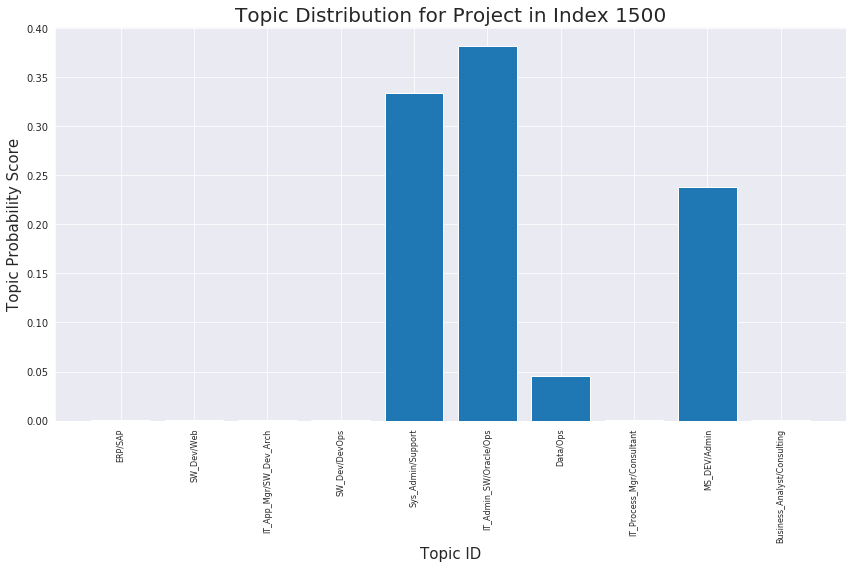

In [86]:
plot_topic_dist(doc_distribution, random_index)

In [553]:
# print the top 5 contributing topics and their words
#for i in doc_distribution.argsort()[-5:][::-1]:
    #print(i, lda.show_topic(topicid=i, topn=10), "\n")

In [253]:
lda_model =  models.LdaModel.load('lda.model')

In [254]:
lda_model.show_topics()

[(0,
  '0.257*"sap" + 0.034*"abap" + 0.027*"berat" + 0.020*"fi" + 0.018*"hana" + 0.015*"mm" + 0.014*"sd" + 0.014*"bw" + 0.013*"consultant" + 0.012*"pp"'),
 (1,
  '0.063*"java" + 0.043*"entwickl" + 0.028*"javascript" + 0.022*"frontend" + 0.019*"spring" + 0.019*"html" + 0.019*"angular" + 0.017*"backend" + 0.016*"net" + 0.015*"css"'),
 (2,
  '0.018*"untersttz" + 0.015*"scrum" + 0.015*"gren" + 0.014*"agil" + 0.011*"jira" + 0.010*"entwickl" + 0.010*"frontend" + 0.009*"april" + 0.009*"bercksicht" + 0.009*"java"'),
 (3,
  '0.063*"java" + 0.033*"devops" + 0.033*"dock" + 0.028*"aws" + 0.026*"cloud" + 0.020*"spring" + 0.018*"jenkin" + 0.018*"kubernet" + 0.017*"data" + 0.016*"mav"'),
 (4,
  '0.119*"windows" + 0.063*"serv" + 0.048*"support" + 0.043*"administration" + 0.034*"cisco" + 0.024*"konfiguration" + 0.023*"microsoft" + 0.022*"netzwerk" + 0.021*"linux" + 0.020*"citrix"'),
 (5,
  '0.037*"oracl" + 0.032*"mobil" + 0.031*"support" + 0.029*"hcm" + 0.021*"installation" + 0.019*"tex" + 0.017*"ios" 

In [270]:
te = """
   Hallo iOS Kollegen,   wir sind ein Team aus Entwicklern, das Software-Dienstleistungen im Bereich Web&Mobile anbietet. Unsere Kunden reichen von kleinen Start Ups bis zu den großen Konzernen. Hauptsächlich sind wir in der Automobilbranche unterwegs und dort ist auch diese Anfrage angesiedelt.   Worum geht es?  Bei einem Automobilhersteller in München möchten wir unser Team um zwei iOS-Entwickler erweitern Es geht um Apps im Umfeld von Connected Car.   Was solltest du mitbringen?  Die wichtigen Buzzwords sind: iOS, Swift, MVVM / VIPER, fastlane, Jenkins, Git, Carthage, Cocoapods, Jira, Confluence, Scrum, Kanban.   Wie sehen die Rahmenbedingungen aus?  Einsatzort: München  Auslastung: bevorzugt Vollzeit (min. 4 Tage pro Woche)  Remoteanteil: 2-3 Tage sind nach der Einarbeitung möglich!!  Start: Es kann gerne direkt morgen los gehen. Der Starttermin richtet sich nach dir, sollte aber in den nächsten 1-2 Monaten liegen.  Dauer: Aktuell werden immer gleich 6 Monate am Stück beauftragt. Das Projekt läuft schon eini anbietet. Unsere Kunden reichen von kleinen Start Ups bis zu den großen Konzernen. Hauptsächlich sind wir in der Automobilbranche unterwegs und dort ist auch diese Anfrage angesiedelt.   Worum geht es?  Bei einem Automobilhersteller in München möchten wir unser Team um zwei iOS-Entwickler erweitern Es geht um Apps im Umfeld von Connected Car.   Was solltest du mitbringen?  Die wichtigen Buzzwords sind: iOS, Swift, MVVM / VIPER, fastlane, Jenkins, Git, Carthage, Cocoapods, Jira, Confluence, Scrum, Kanban.   Wie sehen die Rahmenbedingungen aus?  Einsatzort: München  Auslastung: bevorzugt Vollzeit (min. 4 Tage pro Woche)  Remoteanteil: 2-3 Tage sind nach der Einarbeitung möglich!!  Start: Es kann gerne direkt morgen los gehen. Der Starttermin richtet sich nach dir, sollte aber in den nächsten 1-2 Monaten liegen.  Dauer: Aktuell werden immer gleich 6 Monate am Stück beauftragt. Das Projekt läuft schon eini
"""

In [262]:
bow2 = dictionary.doc2bow(te)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [261]:
doc_distribution1 = np.array([topic[1] for topic in lda_model.get_document_topics(bow=bow2)])
labels = np.argmax(doc_distribution1)
print(doc_distribution1)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


# New Unseen Test Data

In [116]:
doc_index = 21

In [117]:
new_doc_bow = dictionary.doc2bow(test_df.iloc[doc_index,3])

In [118]:
print(test_df.iloc[doc_index,1])

Constaff GmbH - FT3966 -Business Analyst SAP (m/w/d)


In [119]:
print(test_df.iloc[doc_index,2])

 www.constaff.com                                                                                 Melden Sie sich jetzt an und bewerben Sie sich direkt!               Jetzt bewerben


In [120]:
new_doc_distr = np.array([topic[1] for topic in lda.get_document_topics(bow=new_doc_bow)])

In [121]:
new_doc_distr

array([3.8614231e-01, 3.0216895e-04, 2.6986357e-02, 3.0216895e-04,
       3.0216895e-04, 1.2975185e-01, 8.2512960e-02, 3.0216895e-04,
       3.0216895e-04, 3.7309566e-01], dtype=float32)

In [280]:
np.sum(new_doc_distr)

1.0

In [285]:
def percentage(data):
    total = np.sum(data)
    perc_arr = np.array([(x/total)*100 for x in data])
    return perc_arr
        

In [290]:
percentage(new_doc_distr).argmax()

0

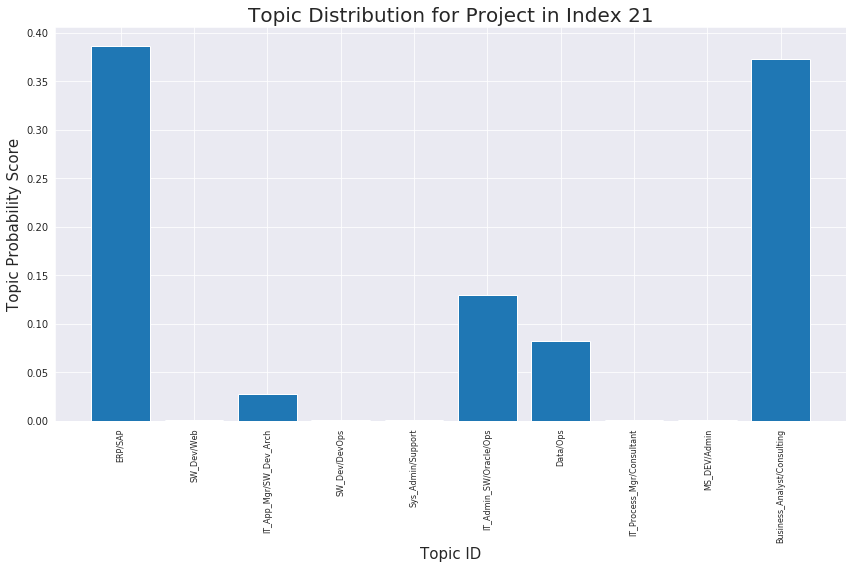

In [122]:
plot_topic_dist(new_doc_distr, doc_index)

In [123]:
# print the top 5 contributing topics and their words
for i in new_doc_distr.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

0 [('sap', 0.2574408), ('abap', 0.034113333), ('berat', 0.027299725), ('fi', 0.01957915), ('hana', 0.017926496), ('mm', 0.015480236), ('sd', 0.014170402), ('bw', 0.0139416875), ('consultant', 0.013281571), ('pp', 0.011597025)] 

9 [('analys', 0.020217404), ('test', 0.016539993), ('business', 0.016052747), ('sql', 0.014643754), ('untersttz', 0.014437441), ('dokumentation', 0.01420158), ('dynamics', 0.012637164), ('technisch', 0.01158817), ('fhigkeit', 0.010902739), ('konzeption', 0.010649218)] 

5 [('oracl', 0.03725483), ('mobil', 0.0316945), ('support', 0.031010525), ('hcm', 0.029264012), ('installation', 0.02111873), ('tex', 0.019225743), ('ios', 0.016515732), ('android', 0.016135529), ('berat', 0.01320271), ('gewnscht', 0.012216892)] 

6 [('business', 0.02679307), ('data', 0.026440825), ('project', 0.024671184), ('development', 0.022986837), ('technical', 0.016004916), ('softwar', 0.015816785), ('support', 0.01577346), ('application', 0.015708894), ('requirement', 0.014066009), ('dev

# Finding similar projects

In [124]:
#list of topics distribution in tuples among all documents
#lda[corpus] => genism_lda bow dictionary
all_topic_distr_list = lda[corpus]

In [125]:
#get each topic probablity distr and convert to an array
#simply a list each documents topic distribution
corpus_topic_dist= np.array([[topic[1] for topic in docs] for docs in all_topic_distr_list])
corpus_topic_dist[:3]

array([[2.3758493e-04, 5.5455029e-01, 2.3758493e-04, 2.3758493e-04,
        1.4340816e-01, 2.3758493e-04, 2.3758493e-04, 2.3758493e-04,
        2.3758493e-04, 3.0037844e-01],
       [1.0160409e-01, 3.7153450e-01, 3.0467334e-01, 1.8489028e-04,
        1.8489028e-04, 1.8489028e-04, 1.8489028e-04, 1.8489028e-04,
        1.8489028e-04, 2.2107874e-01],
       [1.0860539e-04, 3.1276412e-02, 1.0860539e-04, 1.0860539e-04,
        3.6310315e-01, 1.0860539e-04, 1.0860539e-04, 1.0860539e-04,
        6.0486025e-01, 1.0860539e-04]], dtype=float32)

In [145]:
#Jensen Shannon Distance calculates the statistical similarity between two documents. 
#The smaller the value , the closer or similare both documents are
#Its symmetric (associative) meaning the similarity value btw A & B is the same btw B & A

def js_similarity_score(doc_distr_query, corpus_distr):
    """
    This function finds the similarity score of a given doc accross all docs in the corpus
    It takes two parameters: doc_distr_query and corpus_distr
    (1) doc_distr_query is the input document query which is an LDA topic distr: list of floats (series)
            [1.9573441e-04,...., 2.7876711e-01]
    (2) corpus_dist is the target corpus containing the LDA topic distr of all documents in the corpus: lists of lists of floats (vector)
            [[1.9573441e-04, 2.7876711e-01, 1.9573441e-04]....[1.9573441e-04,...., 2.7876711e-01]]
    It returns an array containing the similarity score of each document in the corpus_dist to the input doc_distr_query
    The output looks like this: [0.3445, 0.35353, 0.5445,.....]
    
    """
    input_doc = doc_distr_query[None,:].T #transpose input
    corpus_doc = corpus_distr.T # transpose corpus
    m = 0.5*(input_doc + corpus_doc)
    sim_score = np.sqrt(0.5*(entropy(input_doc,m) + entropy(corpus_doc,m)))
    return sim_score

In [146]:
def find_top_similar_docs(doc_distr_query, corpus_distr,n=10):
    """
    This function returns the index lists of the top n most similar documents using the js_similarity_score
    n can be changed to any amount desired, default is 10
    """
    sim_score = js_similarity_score(doc_distr_query, corpus_distr)
    similar_docs_index_array = sim_score.argsort()[:n] #argsort sorts from lower to higher
    return similar_docs_index_array

In [164]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

18


In [303]:
with open('traindata.sav', 'wb') as output:
    pickle.dump(train_df, output)

In [321]:
appdata = train_df[['title', 'description']]
appdata.head()

,title,description
0,IT Sicherheit Consultant (m/w/d),Projektbeschreibung ...
1,Ihre Unterstützung: 1050 SAP Hybris Entwickler,Projektbeschreibung ...
2,Systemarchitekt Linux (m/w/d) - Hamburg - 4855...,Projektbeschreibung ...
3,Windows/ Office Migration m/w/d,Projektbeschreibung ...
4,"Software Architekt (m/w/d) Automotive in ANÜ, ...",Projektbeschreibung ...


In [323]:
with open('APP_DATA.sav', 'wb') as output:
    pickle.dump(appdata, output)

In [307]:
def recommend(text):
    clean = all_processing(text)
    text_bow = dictionary.doc2bow(clean)
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=text_bow)])
    corpus_topic_dist= np.array([[topic[1] for topic in docs] for docs in all_topic_distr_list])
    similar_docs_index = find_top_similar_docs(new_doc_distribution, corpus_topic_dist)
    top_sim_doc = train_df[train_df.index.isin(similar_docs_index)]
    PROJECT_DICT = top_sim_doc.to_dict() 
    return PROJECT_DICT
    

In [308]:
new_proj = """
Für unseren Kunden aus dem Bankenumfeld in Frankfurt am Main sind wir aktuell auf der Suche nach einem Full-Stack Java Entwickler (m/w/d) im Bereich CI/CD . 

Falls Sie die folgende Projektbeschreibung interessiert und Sie die Anforderungen ausreichend abdecken, bitten wir Sie um kurzfristige Rückmeldung unter Angabe Ihrer Kontaktdaten, Ihrer Konditionen für den genannten Einsatzort (Stunden- oder Tagessatz) sowie Ihres Profils (vorzugsweise in Word).
Gerne können Sie uns dieses per E-Mail an schicken. Da der E-Mailversand bekanntermaßen nicht zu den sichersten Datenübertragungen zählt, möchten wir Ihnen zusätzlich eine sichere und verschlüsselte Upload-Möglichkeit für Ihre Bewerbungsunterlagen anbieten. Nutzen Sie dazu die Schaltfläche „Bewerben“ in unserem Projektportal unter https://mindheads.de.

Projektstandort: Frankfurt am Main
Dauer: 
Abgabefrist beim Kunden: zeitnah

Kurzbeschreibung Projekt:
 
Als Software Engineer / Java Fullstack Developer (m/w/d) im CI-CD & Agile QA-Cluster sind Sie an der Einrichtung, Entwicklung und Verwaltung von Softwareprozessen innerhalb der Systeme Continuous Delivery und Continuous Integration des Kunden beteiligt. Sie unterstützen die Einführung, Wartung und Betreuung neuer und bestehender Produkte im Software-Lebenszyklus. Die Zusammenarbeit basiert auf agilen Methoden und besteht aus einem Team von Business Analysten, Softwarearchitekten, Scrum Mastern und anderen Spezialisten mit unterschiedlichem Hintergrund.

Wichtig: Der Kandidat muss fest angestellt sein! 
 
Aufgaben:
Weiterentwicklung des CI/CD Clusters 
Übertragung von Konzepten, Designs und Architekturmodelle in die Micro-Service-Architektur 
Design und Implementierung von REST-APIs
Design und Implementierung von Web-Frontends 

Anforderungen:
Fundierte Erfahrung in der Full-Stack Java / Java EE-Entwicklung mit Schwerpunkt auf Micro Service Architektur,
Fundierte Erfahrung in agilen Arbeitsmethoden.
Expertise in Web-Frontends z.B. React, Angular
Umfangreiche Erfahrung mit Spring Boot
Umfangreiche Erfahrung mit RDBMS (Oracle) und SQL
Sehr gute Kenntnisse von SSL / TLS (Kerberos, SAML, OAuth, etc.), HTTP-Protokollen, UML und Design Patterns
Sehr gute Kenntnisse in Wort und Schrift Deutsch und Englisch
Erfahrung in der Cloud-Entwicklung (Openshift) wünschenswert

 

Für Fragen, Anregungen oder Wünsche stehen wir Ihnen gern zur Verfügung. Aktuelle Informationen über uns sowie weitere Vakanzen finden Sie auch auf unserer Homepage: https://mindheads.de
"""

In [310]:
pr = recommend(new_proj)

In [320]:
pr.title[595]

AttributeError: 'dict' object has no attribute 'title'

In [ ]:
PROJECT_DICT = dict(zip(train_df['title'], train_df['description']))
PROJECT_DICT

In [165]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,3])
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

In [218]:
a = ""

In [221]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=b)])

In [222]:
# this is surprisingly fast
similar_docs_index = find_top_similar_docs(new_doc_distribution, corpus_topic_dist)

In [223]:
similar_docs_index

array([3839,  976, 1076, 1642, 3007,  274,  349, 3546, 1856, 2956])

In [225]:
top_sim_docs = train_df[train_df.index.isin(similar_docs_index)]
top_sim_docs['title']

274     Ref.Nr: 224711 - Entwickler (m/w/d) für Automa...
349     Projekt: Java Entwicklung in einer Cloud Umgebung
976             Testautomatisierer mit SQL Know-How (m/w)
1076                                        AWS Developer
1642       Data Management Expert / Data Engineer (m/w/d)
1856    Embedded Softwareentwickler C/C++ (m/w/d) im L...
2956    Data Engineer (m/w/d) im Dev/Ops BI Team für E...
3007    Business Analyst in der Wertpapierabwicklung f...
3546              DevOps BI Unterstützung (m/w/d) gesucht
3839         Data Management Expert / Data Engineer (m/w)
Name: title, dtype: object

In [278]:
def predict_bereich(text, lda_model):
    clean = all_processing(text)
    text_bow = dictionary.doc2bow(clean)
    topic_distr_array = np.array([topic[1] for topic in lda_model.get_document_topics(bow=text_bow)])
    plot_topic_dist(topic_distr_array, 1)
    #return topic_distr_array
    for i in topic_distr_array.argsort()[-5:][::-1]:
        print(i, lda_model.show_topic(topicid=i, topn=10), "\n")
    return topic_distr_array, clean, text_bow
    

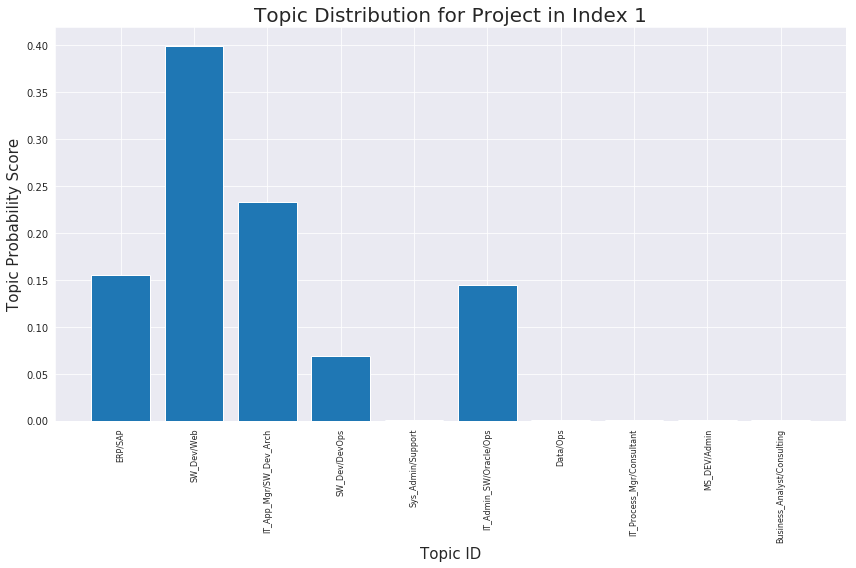

1 [('java', 0.06324196), ('entwickl', 0.043169603), ('javascript', 0.028309654), ('frontend', 0.02160126), ('spring', 0.01886364), ('html', 0.018796254), ('angular', 0.018596003), ('backend', 0.01668937), ('net', 0.016409265), ('css', 0.014961284)] 

2 [('untersttz', 0.01787948), ('scrum', 0.015215177), ('gren', 0.015010036), ('agil', 0.014163819), ('jira', 0.010569038), ('entwickl', 0.010216153), ('frontend', 0.009783334), ('april', 0.009464372), ('bercksicht', 0.008819838), ('java', 0.008659763)] 

0 [('sap', 0.2574408), ('abap', 0.034113333), ('berat', 0.027299725), ('fi', 0.01957915), ('hana', 0.017926496), ('mm', 0.015480236), ('sd', 0.014170402), ('bw', 0.0139416875), ('consultant', 0.013281571), ('pp', 0.011597025)] 

5 [('oracl', 0.03725483), ('mobil', 0.0316945), ('support', 0.031010525), ('hcm', 0.029264012), ('installation', 0.02111873), ('tex', 0.019225743), ('ios', 0.016515732), ('android', 0.016135529), ('berat', 0.01320271), ('gewnscht', 0.012216892)] 

3 [('java', 0.063

In [279]:
t, c, b = predict_bereich(te, lda_model)

In [268]:
t

array([1.6741897e-01, 4.4497436e-01, 2.2639994e-01, 3.9855257e-04,
       3.9855257e-04, 1.5881538e-01, 3.9855257e-04, 3.9855257e-04,
       3.9855257e-04, 3.9855257e-04], dtype=float32)

In [193]:
check1 = dictionary.doc2bow(t)


[(9, 1),
 (13, 1),
 (17, 6),
 (26, 1),
 (31, 1),
 (39, 2),
 (43, 2),
 (63, 1),
 (70, 3),
 (107, 1),
 (108, 1),
 (122, 1),
 (135, 3),
 (136, 1),
 (161, 1),
 (168, 1),
 (191, 2),
 (193, 1),
 (206, 1),
 (215, 1),
 (220, 1),
 (223, 1),
 (224, 1),
 (247, 5),
 (248, 2),
 (256, 1),
 (269, 2),
 (274, 1),
 (280, 1),
 (282, 2),
 (285, 1),
 (290, 1),
 (293, 1),
 (300, 1),
 (305, 1),
 (307, 1),
 (309, 1),
 (316, 2),
 (320, 3),
 (324, 1),
 (349, 2),
 (351, 1),
 (357, 1),
 (368, 1),
 (386, 1),
 (407, 1),
 (416, 2),
 (418, 1),
 (425, 1),
 (439, 1),
 (460, 1),
 (481, 2),
 (484, 1),
 (501, 1),
 (521, 1),
 (565, 1),
 (571, 1),
 (575, 2),
 (587, 1),
 (590, 1),
 (616, 1),
 (619, 1),
 (621, 2),
 (630, 1),
 (631, 1),
 (656, 1),
 (660, 1),
 (664, 1),
 (667, 1),
 (687, 1),
 (689, 3),
 (723, 5),
 (726, 1),
 (731, 1),
 (734, 1),
 (735, 1),
 (741, 1),
 (743, 1),
 (744, 1),
 (745, 1),
 (747, 1),
 (752, 1),
 (753, 1),
 (757, 2),
 (784, 1),
 (819, 1),
 (886, 1),
 (894, 1),
 (944, 2),
 (945, 1),
 (950, 1),
 (960, 1)

In [179]:
c

['android',
 'entwickl',
 'ausreich',
 'abdeck',
 'kurzfrist',
 'rckmeldung',
 'kondition',
 'stund',
 'tagessatz',
 'vorzugsweis',
 'wordgern',
 'emailversand',
 'bekannterma',
 'sicherst',
 'datenbertrag',
 'zhlt',
 'mchten',
 'zustzlich',
 'sich',
 'verschlsselt',
 'uploadmg',
 'anbiet',
 'schaltflch',
 'projektportal',
 'projektstandort',
 'onsitedau',
 'volum',
 'ptabgabefrist',
 'durchfhr',
 'aufwandschtz',
 'implementier',
 'inbetriebnahm',
 'notwend',
 'aufwnd',
 'anforderungskontext',
 'notwend',
 'funktion',
 'technisch',
 'codier',
 'erford',
 'funktion',
 'auftraggeb',
 'eingesetzt',
 'entwicklungswerkzeug',
 'framework',
 'bibliothek',
 'betriebssyst',
 'android',
 'juniteet',
 'untersttz',
 'testautomatisier',
 'jeweil',
 'aufgabenbezug',
 'notwend',
 'vollstndig',
 'dokumentation',
 'geltend',
 'projektspezif',
 'werkzeug',
 'eng',
 'disziplin',
 'business',
 'user',
 'consulting',
 'test',
 'beheb',
 'fehl',
 'testphas',
 'applikation',
 'entwickl',
 'implementiert',
 '

In [24]:
def clean_lower_tokenize(text):
    """
    Function to clean, lower and tokenize texts
    Returns a list of cleaned and tokenized text
    """
    #text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)  #remove websites texts like email, https, www
    text = re.sub("[^a-zA-Z ]", "", text) #remove non alphbetic text
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

In [25]:
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stopwords]

In [26]:
def stem_eng_german_words(text):
    """
    Function to stem words
    """
    try:
        text = [stemmer_germ.stem(word) for word in text]
        #text = [stemmer_eng.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError:
        pass
    return text

In [27]:
def all_processing(text):
    """
    This function applies all the functions above into one
    """
    return stem_eng_german_words(remove_stop_words(clean_lower_tokenize(text)))